In [1]:
from portfolio_optimization.data_processing import *
from portfolio_optimization.data_collection import *
from datetime import datetime, timezone, timedelta
from tokens.get_assets import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, plotting

High risk tickers: 15
Medium risk tickers: 60
Low risk tickers: 8
            1inch         ach      alpaca       alpha         amp         ape  \
count  244.000000  244.000000  244.000000  244.000000  244.000000  244.000000   
mean     0.452799    0.022214    0.244956    0.108844    0.003521    3.894562   
std      0.090188    0.010878    0.053876    0.018815    0.001021    1.093618   
min      0.260083    0.007449    0.138795    0.064544    0.001977    1.883340   
25%      0.393459    0.010763    0.208929    0.098030    0.002921    3.292932   
50%      0.464611    0.020820    0.257531    0.108118    0.003482    3.970119   
75%      0.526397    0.031385    0.289781    0.119999    0.004093    4.511598   
max      0.688143    0.045661    0.332865    0.153101    0.007440    6.293211   

             atom       audio         ava         axs  ...         rpl  \
count  244.000000  244.000000  244.000000  244.000000  ...  244.000000   
mean    10.992625    0.228200    0.586413    7.834980  .

<Axes: xlabel='date'>

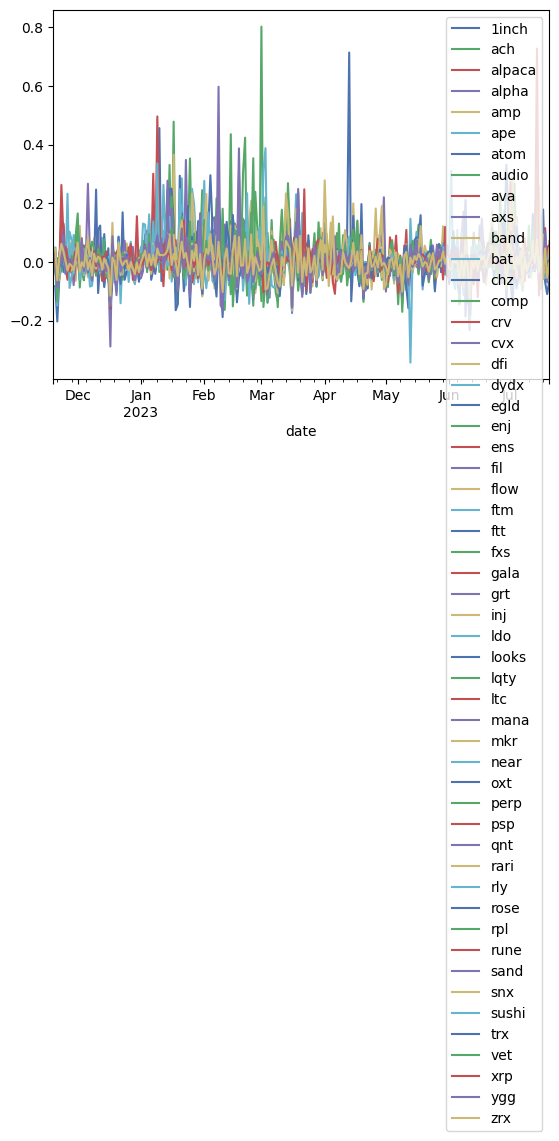

In [2]:
asset_list = get_tickers()
df = get_historical_prices_for_assets(asset_list['medium_risk_tickers'])
# Print comprehensive statistical summary
print(df.describe())

# this will give you the percentage change
df_percentage_variation = df.pct_change()

# plot variation of each asset's price
df_percentage_variation.plot()

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/num

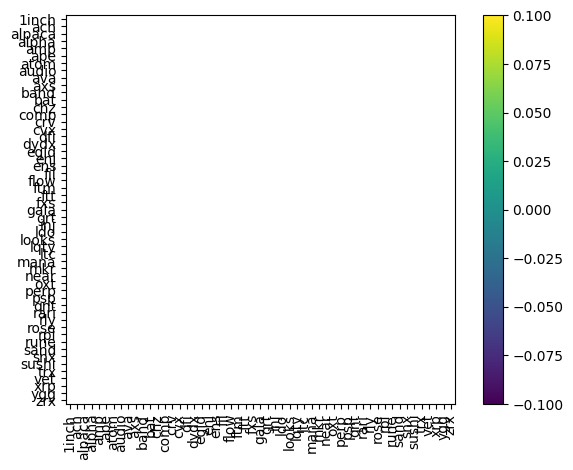

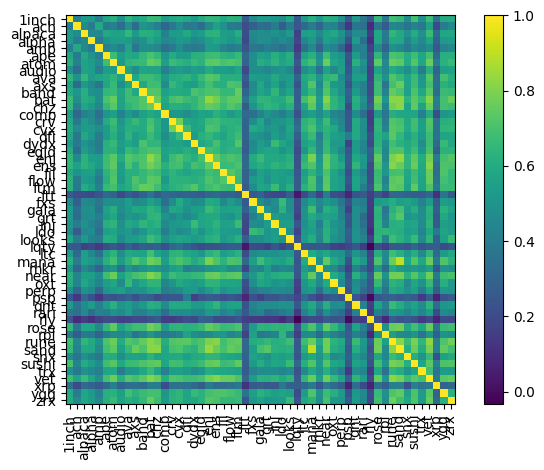

In [3]:
past_df, future_df = df.iloc[:-250], df.iloc[-250:]
future_cov = risk_models.sample_cov(future_df)

sample_cov = risk_models.sample_cov(past_df)
plotting.plot_covariance(sample_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

In [4]:
rets = expected_returns(df)
rets.tail()

,1inch,ach,alpaca,alpha,amp,ape,atom,audio,ava,axs,...,rpl,rune,sand,snx,sushi,trx,vet,xrp,ygg,zrx
date,,,,,,,,,,,,,,,,,,,,,
2023-07-16,0.100950,0.008606,0.036382,0.018387,0.005391,0.009830,-0.006085,0.005553,0.011828,-0.010628,...,-0.010858,0.005444,0.006690,0.022300,-0.007823,0.013126,0.007508,-0.010670,0.016638,0.023131
2023-07-17,0.179038,-0.033119,-0.032959,-0.020110,-0.020102,-0.038789,-0.030736,-0.033853,0.047582,-0.018706,...,-0.012229,-0.018009,-0.023864,-0.058234,0.005285,-0.012337,-0.010912,0.049254,-0.008731,-0.045322
2023-07-18,-0.068466,-0.000491,-0.014016,0.029222,-0.010865,-0.001623,0.004615,0.032222,-0.042090,0.023514,...,-0.027147,-0.001149,0.024004,0.005577,0.092301,0.001512,0.001095,-0.012144,0.106698,0.046737
2023-07-19,-0.108919,-0.057140,-0.029411,-0.020917,-0.015086,0.031261,-0.018040,-0.032830,-0.024540,-0.009084,...,-0.029098,-0.027683,-0.023927,-0.017700,-0.029926,-0.002158,-0.019259,0.050722,-0.069145,-0.053579
2023-07-20,-0.067349,-0.011315,0.021889,-0.000798,-0.006549,0.004327,-0.010121,-0.001759,0.027170,0.015963,...,-0.033956,0.010412,-0.000221,0.041833,-0.021255,0.005764,0.002232,0.057089,-0.009579,-0.002700


In [5]:
# exp_cov = risk_models.exp_cov(past_df)
# plotting.plot_covariance(exp_cov, plot_correlation=True)
# plotting.plot_covariance(future_cov, plot_correlation=True)
# plt.show()

HRP Optimization
================

In [6]:
from portfolio_optimization.optimization.hrp import HRPOptimization

hrp = HRPOptimization(df, rets=rets)
hrp_weights = hrp.get_weights()
hrp_weights

OrderedDict([('1inch', 0.01948),
             ('ach', 0.00651),
             ('alpaca', 0.03675),
             ('alpha', 0.02088),
             ('amp', 0.01707),
             ('ape', 0.01702),
             ('atom', 0.02356),
             ('audio', 0.01357),
             ('ava', 0.02271),
             ('axs', 0.01),
             ('band', 0.02088),
             ('bat', 0.015),
             ('chz', 0.02244),
             ('comp', 0.01175),
             ('crv', 0.02022),
             ('cvx', 0.01945),
             ('dfi', 0.04442),
             ('dydx', 0.00692),
             ('egld', 0.02776),
             ('enj', 0.01176),
             ('ens', 0.01349),
             ('fil', 0.01263),
             ('flow', 0.01105),
             ('ftm', 0.0093),
             ('ftt', 0.01132),
             ('fxs', 0.01184),
             ('gala', 0.01191),
             ('grt', 0.00716),
             ('inj', 0.00873),
             ('ldo', 0.00824),
             ('looks', 0.01341),
             ('lqty', 0.013

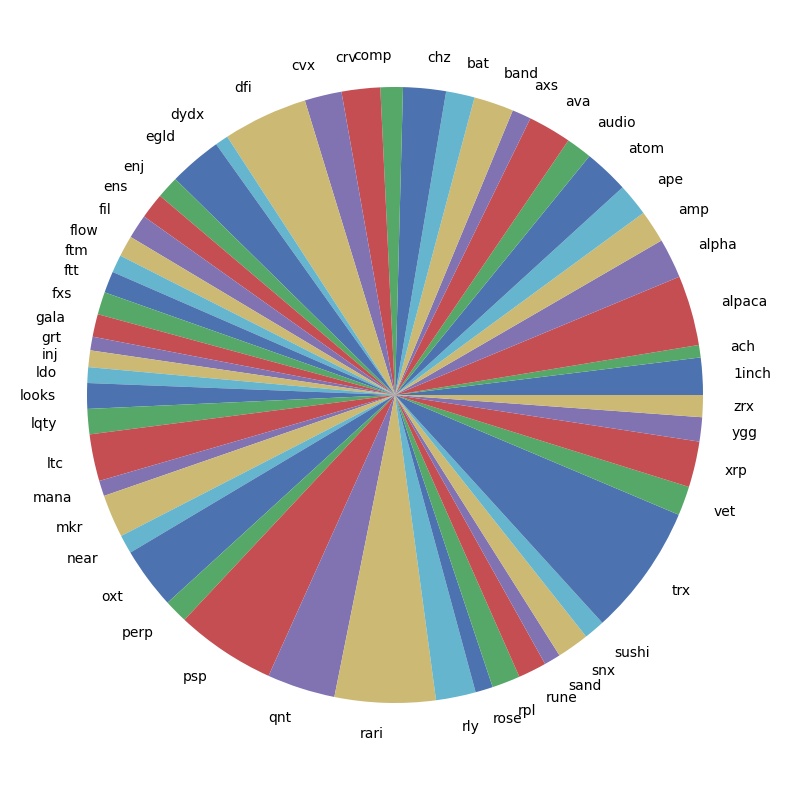

In [7]:
pd.Series(hrp_weights).plot.pie(figsize=(10, 10));

In [8]:
hrp.get_metrics()

{'apy': 0.17539107078027477,
 'annual_volatility': 0.46769449217951337,
 'sharpe_ratio': 0.3322490928985147}

# Markowitz optimization

/Users/arguiot/Developer/Pyratz/portfolio/portfolio_optimization/optimization/markowitz.py:116: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


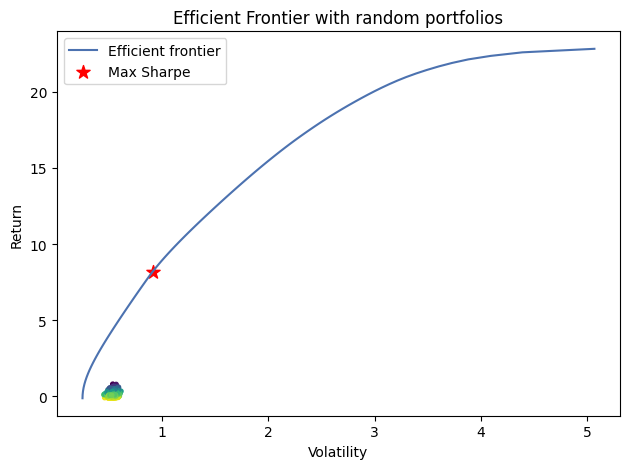

In [9]:
from portfolio_optimization.optimization.markowitz import Markowitz

markowitz = Markowitz(df)

markowitz_weights = markowitz.get_weights()
markowitz.plot_frontier()

OrderedDict([('1inch', -0.11138), ('ach', 0.22997), ('alpaca', -0.00279), ('alpha', 0.06154), ('amp', -0.15886), ('ape', -0.29406), ('atom', -0.00017), ('audio', 0.07708), ('ava', -0.19811), ('axs', -0.0737), ('band', -0.38388), ('bat', -0.2139), ('chz', -0.48125), ('comp', 0.33926), ('crv', 0.27263), ('cvx', -0.24093), ('dfi', -0.37755), ('dydx', -0.27176), ('egld', 0.32065), ('enj', 0.18138), ('ens', -0.43885), ('fil', -0.30134), ('flow', -0.06904), ('ftm', -0.04895), ('ftt', 0.05328), ('fxs', 0.03574), ('gala', 0.14306), ('grt', 0.13403), ('inj', 1.0), ('ldo', -0.15141), ('looks', -0.22174), ('lqty', -0.00347), ('ltc', 0.35079), ('mana', 0.18529), ('mkr', 0.24303), ('near', -0.00443), ('oxt', -0.05945), ('perp', 0.09498), ('psp', 0.12993), ('qnt', 0.13491), ('rari', -0.01585), ('rly', 0.13026), ('rose', -0.07651), ('rpl', 0.40652), ('rune', -0.17407), ('sand', -0.42165), ('snx', -0.06821), ('sushi', -0.19064), ('trx', 1.0), ('vet', -0.20374), ('xrp', 0.37354), ('ygg', 0.06157), ('zr

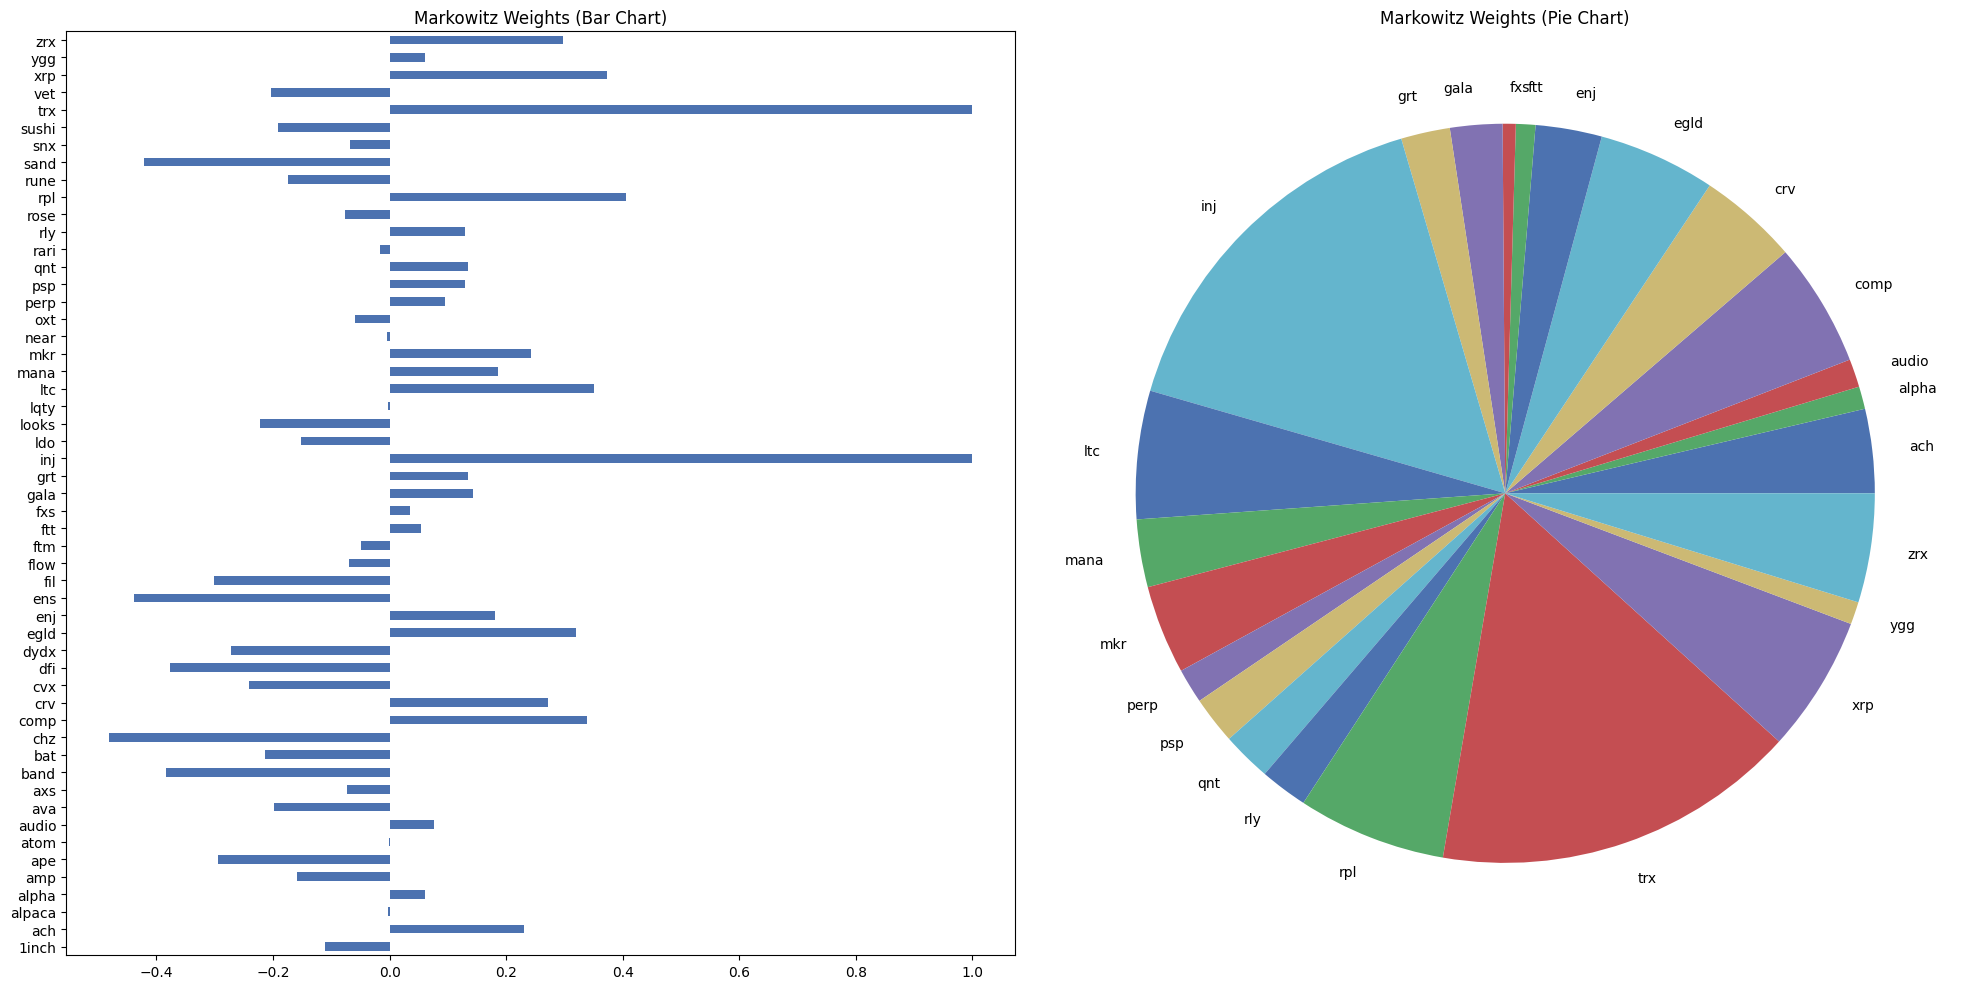

In [10]:
print(markowitz_weights)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Bar chart on the left
pd.Series(markowitz_weights).plot(kind='barh', ax=axes[0], title="Markowitz Weights (Bar Chart)")

# Pie chart on the right without negative values
pd_weights = pd.Series(markowitz_weights)
positive_weights = pd_weights[pd_weights > 0]
positive_weights.plot(kind='pie', ax=axes[1], title="Markowitz Weights (Pie Chart)")

plt.tight_layout()
plt.show()

In [11]:
markowitz.get_metrics()

{'apy': 8.192520948874456,
 'annual_volatility': 0.9133577404473412,
 'sharpe_ratio': 8.947776524970104}

In [14]:
from portfolio_optimization.portfolio import weight_diff

diffs = weight_diff(markowitz_weights, hrp_weights, threshold=0.05)
print(len(diffs))
diffs

2


[('trx', 'Sell', 0.0804660182763788), ('inj', 'Sell', 0.08566685276055591)]